# Imports

In [1]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sn
sn.set(font_scale=1.4) # for label size
import multiprocessing as mp
import csv

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [ ]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [ ]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

In [ ]:
# combine training and validation data - for cross-validation
X_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))

## Load Test Set

In [ ]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

# Pre-Process DataSet

In [ ]:
# pre-process data 
def scale_pixels(train, val, test, X_all):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
  X_all_norm = X_all.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm, X_all_norm

X_train, X_val, X_test, X_all = scale_pixels(X_train, X_val, X_test, X_all)

# Plot Diagnostics

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

# Create CNN Model

In [ ]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Weight Regularization

In [ ]:
# define cnn model
def define_model_weight_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [ ]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=10, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,1e-5, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,1e-6, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,5e-5, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,2e-5, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,7e-6, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,9e-6, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Data Augmentation

In [9]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=10, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 1e-5, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
156/156 [==============================] - 365s 2s/step - loss: 1.0854 - accuracy: 0.4826 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/75
156/156 [==============================] - 362s 2s/step - loss: 1.0287 - accuracy: 0.4997 - val_loss: 0.7004 - val_accuracy: 0.5005
Epoch 3/75
156/156 [==============================] - 364s 2s/step - loss: 0.9881 - accuracy: 0.5271 - val_loss: 0.6973 - val_accuracy: 0.5255
Epoch 4/75
156/156 [==============================] - 364s 2s/step - loss: 0.9693 - accuracy: 0.5466 - val_loss: 0.6752 - val_accuracy: 0.5945
Epoch 5/75
156/156 [==============================] - 364s 2s/step - loss: 0.9534 - accuracy: 0.5458 - val_loss: 0.6567 - val_accuracy: 0.6470
Epoch 6/75
156/156 [==============================] - 364s 2s/step - loss: 0.9140 - accuracy: 0.5849 - val_loss: 0.6375 - val_accuracy: 0.6975
Epoch 7/75
156/156 [==============================] - 364s 2s/step - loss: 0.8989 - accuracy: 0.5902 - val_loss: 0.6231 - val_accuracy: 0.7055

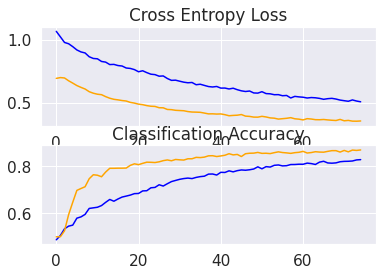

In [14]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 1e-6, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))=
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
156/156 [==============================] - 341s 2s/step - loss: 1.0622 - accuracy: 0.5130 - val_loss: 0.7008 - val_accuracy: 0.5000
Epoch 2/75
156/156 [==============================] - 338s 2s/step - loss: 0.8900 - accuracy: 0.5797 - val_loss: 0.7316 - val_accuracy: 0.4980
Epoch 3/75
156/156 [==============================] - 335s 2s/step - loss: 0.8493 - accuracy: 0.6156 - val_loss: 0.7017 - val_accuracy: 0.5195
Epoch 4/75
156/156 [==============================] - 336s 2s/step - loss: 0.8074 - accuracy: 0.6403 - val_loss: 0.6028 - val_accuracy: 0.6595
Epoch 5/75
156/156 [==============================] - 336s 2s/step - loss: 0.7700 - accuracy: 0.6625 - val_loss: 0.5172 - val_accuracy: 0.7805
Epoch 6/75
156/156 [==============================] - 337s 2s/step - loss: 0.7274 - accuracy: 0.6959 - val_loss: 0.4758 - val_accuracy: 0.8135
Epoch 7/75
156/156 [==============================] - 336s 2s/step - loss: 0.7187 - accuracy: 0.7093 - val_loss: 0.4437 - val_accuracy: 0.8310

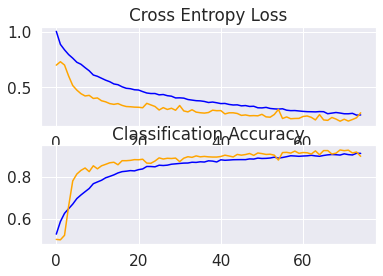

In [11]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 5e-6, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
156/156 [==============================] - 364s 2s/step - loss: 0.9982 - accuracy: 0.5545 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 2/75
156/156 [==============================] - 364s 2s/step - loss: 0.8565 - accuracy: 0.6196 - val_loss: 0.7239 - val_accuracy: 0.5000
Epoch 3/75
156/156 [==============================] - 362s 2s/step - loss: 0.7882 - accuracy: 0.6676 - val_loss: 0.7087 - val_accuracy: 0.5130
Epoch 4/75
156/156 [==============================] - 362s 2s/step - loss: 0.7179 - accuracy: 0.7127 - val_loss: 0.5488 - val_accuracy: 0.7040
Epoch 5/75
156/156 [==============================] - 362s 2s/step - loss: 0.6910 - accuracy: 0.7247 - val_loss: 0.4581 - val_accuracy: 0.8020
Epoch 6/75
156/156 [==============================] - 359s 2s/step - loss: 0.6389 - accuracy: 0.7524 - val_loss: 0.3996 - val_accuracy: 0.8500
Epoch 7/75
156/156 [==============================] - 360s 2s/step - loss: 0.6029 - accuracy: 0.7799 - val_loss: 0.3819 - val_accuracy: 0.8545

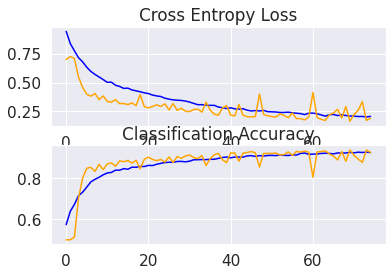

In [10]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 8e-6, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Weight Regularization

In [ ]:
def train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_weight, accuracy = train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, 1e-5, 75)
print(accuracy)
y_pred = model_test_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 344s 2s/step - loss: 94.4172 - accuracy: 0.5115 - val_loss: 94.0703 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 338s 2s/step - loss: 94.3598 - accuracy: 0.5296 - val_loss: 94.0396 - val_accuracy: 0.5000
Epoch 3/75
157/157 [==============================] - 336s 2s/step - loss: 94.3281 - accuracy: 0.5487 - val_loss: 94.0039 - val_accuracy: 0.6200
Epoch 4/75
157/157 [==============================] - 335s 2s/step - loss: 94.2494 - accuracy: 0.5762 - val_loss: 93.9763 - val_accuracy: 0.6895
Epoch 5/75
157/157 [==============================] - 335s 2s/step - loss: 94.2418 - accuracy: 0.5721 - val_loss: 93.9467 - val_accuracy: 0.7150
Epoch 6/75
157/157 [==============================] - 340s 2s/step - loss: 94.2215 - accuracy: 0.5915 - val_loss: 93.9217 - val_accuracy: 0.7380
Epoch 7/75
157/157 [==============================] - 336s 2s/step - loss: 94.1906 - accuracy: 0.6108 - val_loss: 93.8998 - val_ac

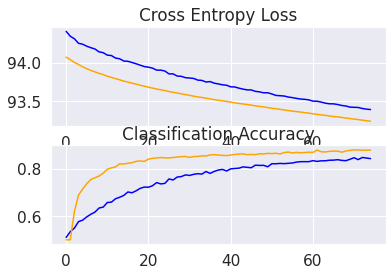

In [11]:
model_test_weight, accuracy = train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, 1e-6, 75)
print(accuracy)
y_pred = model_test_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 339s 2s/step - loss: 94.2357 - accuracy: 0.5759 - val_loss: 93.8576 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 336s 2s/step - loss: 93.6185 - accuracy: 0.7810 - val_loss: 93.9368 - val_accuracy: 0.5000
Epoch 3/75
157/157 [==============================] - 336s 2s/step - loss: 93.2121 - accuracy: 0.8403 - val_loss: 93.6976 - val_accuracy: 0.5125
Epoch 4/75
157/157 [==============================] - 335s 2s/step - loss: 92.8414 - accuracy: 0.8704 - val_loss: 93.1065 - val_accuracy: 0.6060
Epoch 5/75
157/157 [==============================] - 336s 2s/step - loss: 92.5059 - accuracy: 0.8863 - val_loss: 92.2326 - val_accuracy: 0.8855
Epoch 6/75
157/157 [==============================] - 336s 2s/step - loss: 92.1791 - accuracy: 0.8906 - val_loss: 91.9835 - val_accuracy: 0.8725
Epoch 7/75
157/157 [==============================] - 336s 2s/step - loss: 91.8825 - accuracy: 0.8943 - val_loss: 91.6606 - val_ac

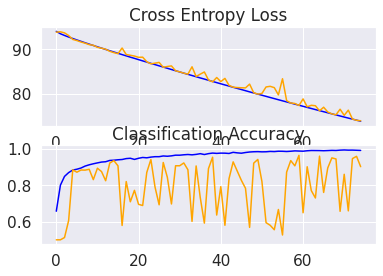

In [11]:
model_test_weight, accuracy = train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, 5e-5, 75)
print(accuracy)
y_pred = model_test_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 380s 2s/step - loss: 94.3815 - accuracy: 0.4969 - val_loss: 93.9924 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 377s 2s/step - loss: 94.1250 - accuracy: 0.6167 - val_loss: 93.9693 - val_accuracy: 0.5000
Epoch 3/75
157/157 [==============================] - 358s 2s/step - loss: 93.9657 - accuracy: 0.6806 - val_loss: 93.8989 - val_accuracy: 0.5110
Epoch 4/75
157/157 [==============================] - 347s 2s/step - loss: 93.8310 - accuracy: 0.7255 - val_loss: 93.6538 - val_accuracy: 0.6740
Epoch 5/75
157/157 [==============================] - 346s 2s/step - loss: 93.7345 - accuracy: 0.7539 - val_loss: 93.4546 - val_accuracy: 0.8440
Epoch 6/75
157/157 [==============================] - 345s 2s/step - loss: 93.6087 - accuracy: 0.7910 - val_loss: 93.3615 - val_accuracy: 0.8620
Epoch 7/75
157/157 [==============================] - 346s 2s/step - loss: 93.5165 - accuracy: 0.8096 - val_loss: 93.2818 - val_ac

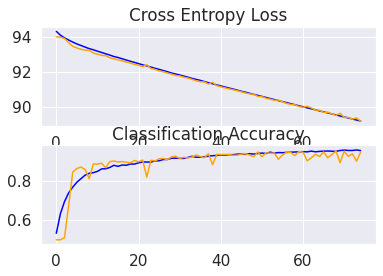

In [10]:
model_test_weight, accuracy = train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, 1e-5, 75)
print(accuracy)
y_pred = model_test_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_weight, accuracy = train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, 2e-5, 75)
print(accuracy)
y_pred = model_test_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Data Augmentation and Weight Regularization 

In [ ]:
def train_data_augmentation_weight(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/75
156/156 [==============================] - 391s 2s/step - loss: 94.3657 - accuracy: 0.5339 - val_loss: 93.9954 - val_accuracy: 0.5000
Epoch 2/75
156/156 [==============================] - 388s 2s/step - loss: 94.1030 - accuracy: 0.6298 - val_loss: 93.9824 - val_accuracy: 0.5000
Epoch 3/75
156/156 [==============================] - 388s 2s/step - loss: 93.9891 - accuracy: 0.6715 - val_loss: 93.9461 - val_accuracy: 0.5060
Epoch 4/75
156/156 [==============================] - 388s 2s/step - loss: 93.8399 - accuracy: 0.7372 - val_loss: 93.6473 - val_accuracy: 0.7025
Epoch 5/75
156/156 [==============================] - 387s 2s/step - loss: 93.7333 - accuracy: 0.7565 - val_loss: 93.4622 - val_accuracy: 0.8455
Epoch 6/75
156/156 [==============================] - 386s 2s/step - loss: 93.6173 - accuracy: 0.7895 - val_loss: 93.4101 - val_accuracy: 0.8415
Epoch 7/75
156/156 [==============================] - 384s 2s/step - loss: 93.5397 - accuracy: 0.8001 - val_loss: 93.2974 - val_ac

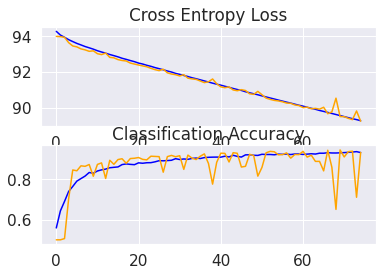

In [11]:
model_test_data_weight, accuracy = train_data_augmentation_weight(X_train, X_val, X_test, y_train, y_val, y_test, 1e-5, 75)
print(accuracy)
y_pred = model_test_data_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
156/156 [==============================] - 328s 2s/step - loss: 94.3874 - accuracy: 0.5135 - val_loss: 94.0660 - val_accuracy: 0.4710
Epoch 2/75
156/156 [==============================] - 322s 2s/step - loss: 94.3526 - accuracy: 0.5270 - val_loss: 94.0494 - val_accuracy: 0.5605
Epoch 3/75
156/156 [==============================] - 320s 2s/step - loss: 94.3637 - accuracy: 0.5205 - val_loss: 94.0234 - val_accuracy: 0.6095
Epoch 4/75
156/156 [==============================] - 324s 2s/step - loss: 94.3116 - accuracy: 0.5422 - val_loss: 94.0081 - val_accuracy: 0.6215
Epoch 5/75
156/156 [==============================] - 320s 2s/step - loss: 94.2835 - accuracy: 0.5606 - val_loss: 93.9938 - val_accuracy: 0.6560
Epoch 6/75
156/156 [==============================] - 321s 2s/step - loss: 94.2498 - accuracy: 0.5705 - val_loss: 93.9784 - val_accuracy: 0.6685
Epoch 7/75
156/156 [==============================] - 320s 2s/step - loss: 94.2474 - accuracy: 0.5800 - val_loss: 93.9620 - val_ac

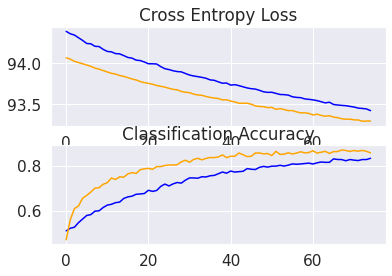

In [18]:
model_test_data_weight, accuracy = train_data_augmentation_weight(X_train, X_val, X_test, y_train, y_val, y_test, 1e-6, 75)
print(accuracy)
y_pred = model_test_data_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))